# 15. How to Generate Art

### Imports

In [1]:
from IPython.display import Image

import numpy as np
from PIL import Image
import time

from keras import backend as K
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


### Load and preprocess images

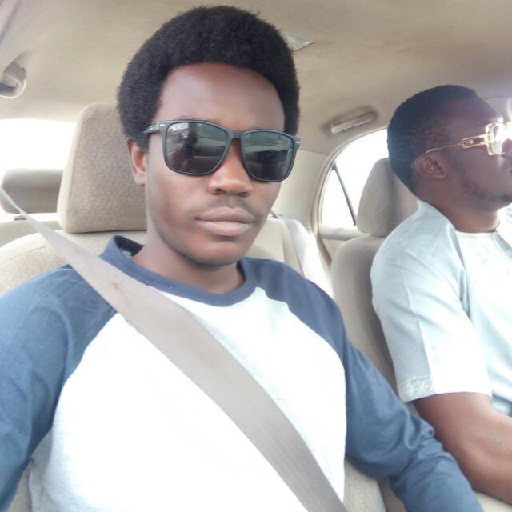

In [2]:
height = 512
width = 512
content_img_path = 'images/victor.jpg'
content_img = Image.open(content_img_path)
content_img = content_img.resize((height, width))
content_img

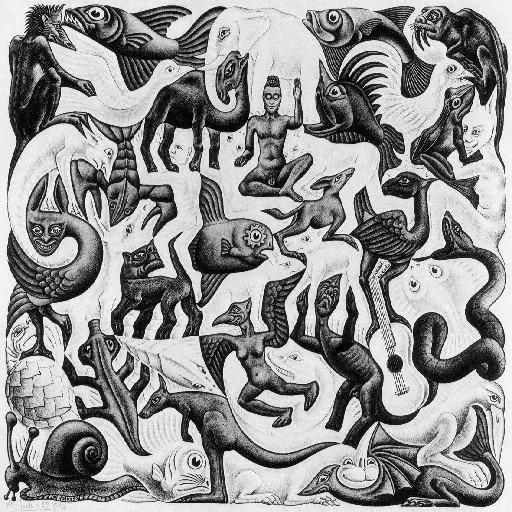

In [3]:
style_img_path = 'images/styles/escher_planefilling2.jpg'
style_img = Image.open(style_img_path)
style_img = style_img.resize((height, width))
style_img

In [4]:
content_array = np.asarray(content_img, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
content_array.shape

(1, 512, 512, 3)

In [5]:
style_array = np.asarray(style_img, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
style_array.shape

(1, 512, 512, 3)

In [6]:
content_array[:,:,:,0] -= 103.939
content_array[:,:,:,1] -= 116.779
content_array[:,:,:,2] -= 123.68
content_array = content_array[:, :, :, ::-1]

In [7]:
style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array = style_array[:, :, :, ::-1]

### Computation Graph

In [8]:
content_img = K.variable(content_array)
style_img = K.variable(style_array)
combination_img = K.placeholder((1, height, width, 3))

### Concatenate all images to a single tensor

In [9]:
input_tensor = K.concatenate([content_img, style_img, combination_img], axis=0)

### Download pre-trained VGG-16 Model

In [10]:
model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
print('Model loaded')

Model loaded


In [11]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [12]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [13]:
loss = K.variable(0.)

### The Content Loss

In [14]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

In [15]:
layer_features = layers['block2_conv2']
content_img_features = layer_features[0,:,:,:]
combination_img_features = layer_features[2,:,:,:]

In [16]:
loss += content_weight * content_loss(content_img_features,
                                     combination_img_features)

### The Style Loss

In [17]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [18]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channel = 3
    size = width * height
    return K.sum(K.square(S-C)) / (4. * (channel**2) * (size**2))

In [19]:
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 
                  'block4_conv3', 'block5_conv3']
for layer_name in feature_layers:
    layer_feature = layers[layer_name]
    style_features = layer_feature[1,:,:,:]
    combination_features = layer_feature[2,:,:,:]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight/len(feature_layers)) * sl

### Total variation loss

In [20]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [21]:
loss += total_variation_weight * total_variation_loss(combination_img)

### Define gradients to solve optimization problem

In [22]:
grads = K.gradients(loss, combination_img)

In [23]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_img], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

### Training

In [24]:
X = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Starting iteration', i)
    start = time.time()
    X, min_val, info = fmin_l_bfgs_b(evaluator.loss, X.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    end = time.time()
    print('Current loss value = {:.4f}'.format(min_val))
    print('Iteration {:,} completed in {}s\n'.format(i, (end-start)))

Starting iteration 0
Current loss value = 221444882432.0000
Iteration 0 completed in 715.4536180496216s

Starting iteration 1
Current loss value = 147898744832.0000
Iteration 1 completed in 687.5916149616241s

Starting iteration 2
Current loss value = 126384381952.0000
Iteration 2 completed in 739.2563228607178s

Starting iteration 3
Current loss value = 115109969920.0000
Iteration 3 completed in 730.4520261287689s

Starting iteration 4
Current loss value = 107908718592.0000
Iteration 4 completed in 718.1033811569214s

Starting iteration 5
Current loss value = 103788396544.0000
Iteration 5 completed in 683.300586938858s

Starting iteration 6
Current loss value = 100920229888.0000
Iteration 6 completed in 685.9427728652954s

Starting iteration 7
Current loss value = 99028172800.0000
Iteration 7 completed in 678.180410861969s

Starting iteration 8
Current loss value = 97445584896.0000
Iteration 8 completed in 674.3544309139252s

Starting iteration 9
Current loss value = 96327450624.0000


### Reconstruct the Image

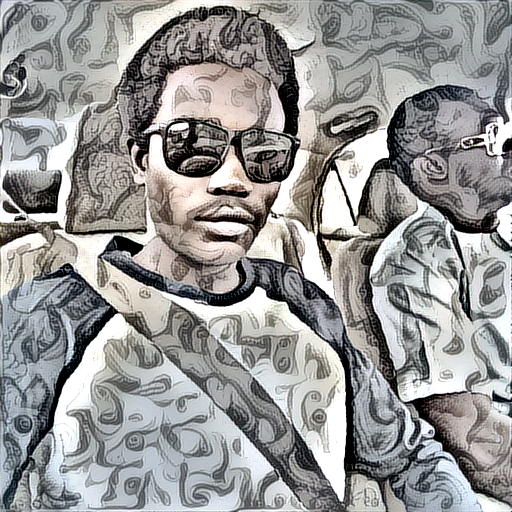

In [25]:
x = X.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)